In [1]:
from sympy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Heizkurve vor Sanierung
symbols https://de.overleaf.com/learn/latex/List_of_Greek_letters_and_math_symbols

tutorial https://docs.sympy.org/latest/explanation/best-practices.html

Im Buch beschriebene Vorgehensweise genutzt, um Heizkurve von unsanierten Fall zu ermitteln
Im nächsten Schritt (Excel) werden neue VLT, RLT und (mittlere) log. Übertemperatur für Sanierungen ermittelt, neues Q geht aus der SIM hervor.
Mit neuem Q, VLT, RLT & Übertemp. werden dann die Formeln erneut genutzt, um die Heizkurve für die Sanierungen zu ermitteln.

## Definieren der Symbole & Formeln

In [2]:
T_VN = Symbol('vartheta_V,N') # Norm-Vorlauftemperatur
# Define the remaining variables from the table
T_RN = Symbol('vartheta_R,N')  # Norm-Rücklauftemperatur
T_aN = Symbol('vartheta_a,N')  # Norm-Außentemperatur
T_i = Symbol('vartheta_i')  # Raumtemperatur
p = Symbol('p')  # Heizflächenexponent
delta_T_mN = Symbol('\\Delta \\vartheta_m,N')  # mittlere Übertemperatur Normzustand
phi = Symbol('varphi')  # Lastverhältnis (Kann aus Simulationsergebnissen entnommen werden)
x = Symbol('x')  # Hilfsgröße
theta_V = Symbol('\\vartheta_V')  # Vorlauftemperatur
T_a = Symbol('\\vartheta_a')  # Außentemperatur
T_aGrenz = Symbol('\\vartheta_{a,Grenz}')  # Grenz-Außentemperatur

## Definieren der Gleichungen

In [3]:
theta_R = theta_V - phi * (T_VN - T_RN)  # Rücklauftemperatur Gl. 5.11
theta_R

\vartheta_V - varphi*(-vartheta_R,N + vartheta_V,N)

In [4]:
theta_V =  (exp(x)*((T_VN - T_RN)*phi+T_i)-T_i)/(exp(x)-1) # Gl. 5.9
theta_V

(-vartheta_i + (varphi*(-vartheta_R,N + vartheta_V,N) + vartheta_i)*exp(x))/(exp(x) - 1)

In [5]:
x = (phi ** (p/(1+p)) * (T_VN - T_RN)) / delta_T_mN # Gl. 5.10
x

varphi**(p/(p + 1))*(-vartheta_R,N + vartheta_V,N)/\Delta \vartheta_m,N

In [6]:
phi = (T_aGrenz - T_a) / (T_aGrenz - T_aN) # Heizlastverhältnis Gl. 5.13
phi

(-\vartheta_a + \vartheta_{a,Grenz})/(\vartheta_{a,Grenz} - vartheta_a,N)

## Einsetzen der Formeln in einander, so dass nur noch $T_a$ als Variable übrig bleibt

In [7]:
# einsetzen von x in theta_V
phi = (T_aGrenz - T_a) / (T_aGrenz - T_aN)
x = (phi ** (p/(1+p)) * (T_VN - T_RN)) / delta_T_mN
theta_V =  (exp(x)*((T_VN - T_RN)*phi+T_i)-T_i)/(exp(x)-1)
theta_R = theta_V - phi * (T_VN - T_RN) 

In [8]:
print(latex(theta_V))

\frac{- \vartheta_{i} + \left(\vartheta_{i} + \frac{\left(- \vartheta_{a} + \vartheta_{a,Grenz}\right) \left(- \vartheta_{R,N} + \vartheta_{V,N}\right)}{\vartheta_{a,Grenz} - \vartheta_{a,N}}\right) e^{\frac{\left(\frac{- \vartheta_{a} + \vartheta_{a,Grenz}}{\vartheta_{a,Grenz} - \vartheta_{a,N}}\right)^{\frac{p}{p + 1}} \left(- \vartheta_{R,N} + \vartheta_{V,N}\right)}{\Delta \vartheta_{m,N}}}}{e^{\frac{\left(\frac{- \vartheta_{a} + \vartheta_{a,Grenz}}{\vartheta_{a,Grenz} - \vartheta_{a,N}}\right)^{\frac{p}{p + 1}} \left(- \vartheta_{R,N} + \vartheta_{V,N}\right)}{\Delta \vartheta_{m,N}}} - 1}


In [9]:
theta_V

(-vartheta_i + (vartheta_i + (-\vartheta_a + \vartheta_{a,Grenz})*(-vartheta_R,N + vartheta_V,N)/(\vartheta_{a,Grenz} - vartheta_a,N))*exp(((-\vartheta_a + \vartheta_{a,Grenz})/(\vartheta_{a,Grenz} - vartheta_a,N))**(p/(p + 1))*(-vartheta_R,N + vartheta_V,N)/\Delta \vartheta_m,N))/(exp(((-\vartheta_a + \vartheta_{a,Grenz})/(\vartheta_{a,Grenz} - vartheta_a,N))**(p/(p + 1))*(-vartheta_R,N + vartheta_V,N)/\Delta \vartheta_m,N) - 1)

## Ersetzen der Variablen durch tatsächliche Werte

In [10]:
def heizkurve(values):
    """ Erstellt die Heizkurve für die gegebenen Werte

    returns: Funktionen für $\\theta_V(T_a)$ und $\\theta_R(T_a)$
    """
    theta_V_subs = theta_V.subs(values)
    theta_R_subs = theta_R.subs(values)
    tehta_V_von_Ta = lambdify(T_a, theta_V_subs)
    tehta_R_von_Ta = lambdify(T_a, theta_R_subs)
    return tehta_V_von_Ta, tehta_R_von_Ta

# Define the values from the table
beispielfall = {
    T_VN:70,
    T_RN:50,
    T_aN:-15,
    T_i:20,
    p:0.3,
    delta_T_mN:39.15,
    T_aGrenz: 20
}
heizkurve_beispielfall = heizkurve(beispielfall)

# Erstellen der Heizkurven für alle Gebäude und Varianten
## Einlesen der Parameter

In [11]:
# Read the Excel file
file_path = '7_Berechnungen_VLT_Heizkurven_wärmenetz.xlsx'
sheet_names = ['Output_Unsaniert', 'Output_Basis','Output_ambitioniert']
dfs = {}
for sheet_name in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet_name,header=1, index_col=0)
    df.name = df.index.name
    dfs[df.name] = df.T
    print(f"Sheet '{df.name}' has been read.")
    display(dfs[df.name])

Sheet 'Unsaniert' has been read.


Unsaniert,FVR,SB,SpS,TV
T_VN,75.000000,75.000000,75.000000,75.000000
T_RN,65.000000,65.000000,65.000000,65.000000
T_aN,-7.000000,-7.000000,-7.000000,-7.000000
T_i,21.000000,21.000000,21.000000,21.000000
p,0.330000,0.330000,0.330000,0.330000
delta_T_mN,48.829457,48.829457,48.829457,48.829457
T_aGrenz,21.000000,21.000000,21.000000,21.000000


Sheet 'Basis' has been read.


Basis,FVR,SB,SpS,TV
T_VN,70.000000,71.100000,70.000000,72.000000
T_RN,60.000000,61.000000,60.000000,62.000000
T_aN,-7.000000,-7.000000,-7.000000,-7.000000
T_i,21.000000,21.000000,21.000000,21.000000
p,0.330000,0.330000,0.330000,0.330000
delta_T_mN,43.809949,44.860666,43.809949,45.818266
T_aGrenz,21.000000,21.000000,21.000000,21.000000


Sheet 'Ambitioniert' has been read.


Ambitioniert,FVR,SB,SpS,TV
T_VN,60.40000,63.000000,63.600000,57.300000
T_RN,50.30000,53.000000,53.600000,48.000000
T_aN,-7.00000,-7.000000,-7.000000,-7.000000
T_i,21.00000,21.000000,21.000000,21.000000
p,0.33000,0.330000,0.330000,0.330000
delta_T_mN,34.10108,36.773667,37.377314,31.420949
T_aGrenz,21.00000,21.000000,21.000000,21.000000


## Berechnen der Heizkurven

In [12]:
heizkurven = {}
for variante in dfs:
    # each row is a building
    for gebaeude in dfs[variante]:
        values = dfs[variante][gebaeude]
        parameter = {
            T_VN: values['T_VN'],
            T_RN: values['T_RN'],
            T_aN: values['T_aN'],
            T_i: values['T_i'],
            p: values['p'],
            delta_T_mN: values['delta_T_mN'],
            T_aGrenz: values['T_aGrenz']
        }
        heizkurven[variante,gebaeude] = heizkurve(parameter)

# Heizkurven für ambitioniert in csv speichern
for variante,gebaeude in heizkurven:
    heizkurven[variante,gebaeude]
    df = pd.DataFrame({
        'T_a': np.arange(-20, 21, 1),
        'theta_V': heizkurven[variante,gebaeude][0](np.arange(-20, 21, 1)),
        'theta_R': heizkurven[variante,gebaeude][1](np.arange(-20, 21, 1))
    })
    df.to_csv(f'{variante}_{gebaeude}.csv', index=False)

## Plot der Heizkurven

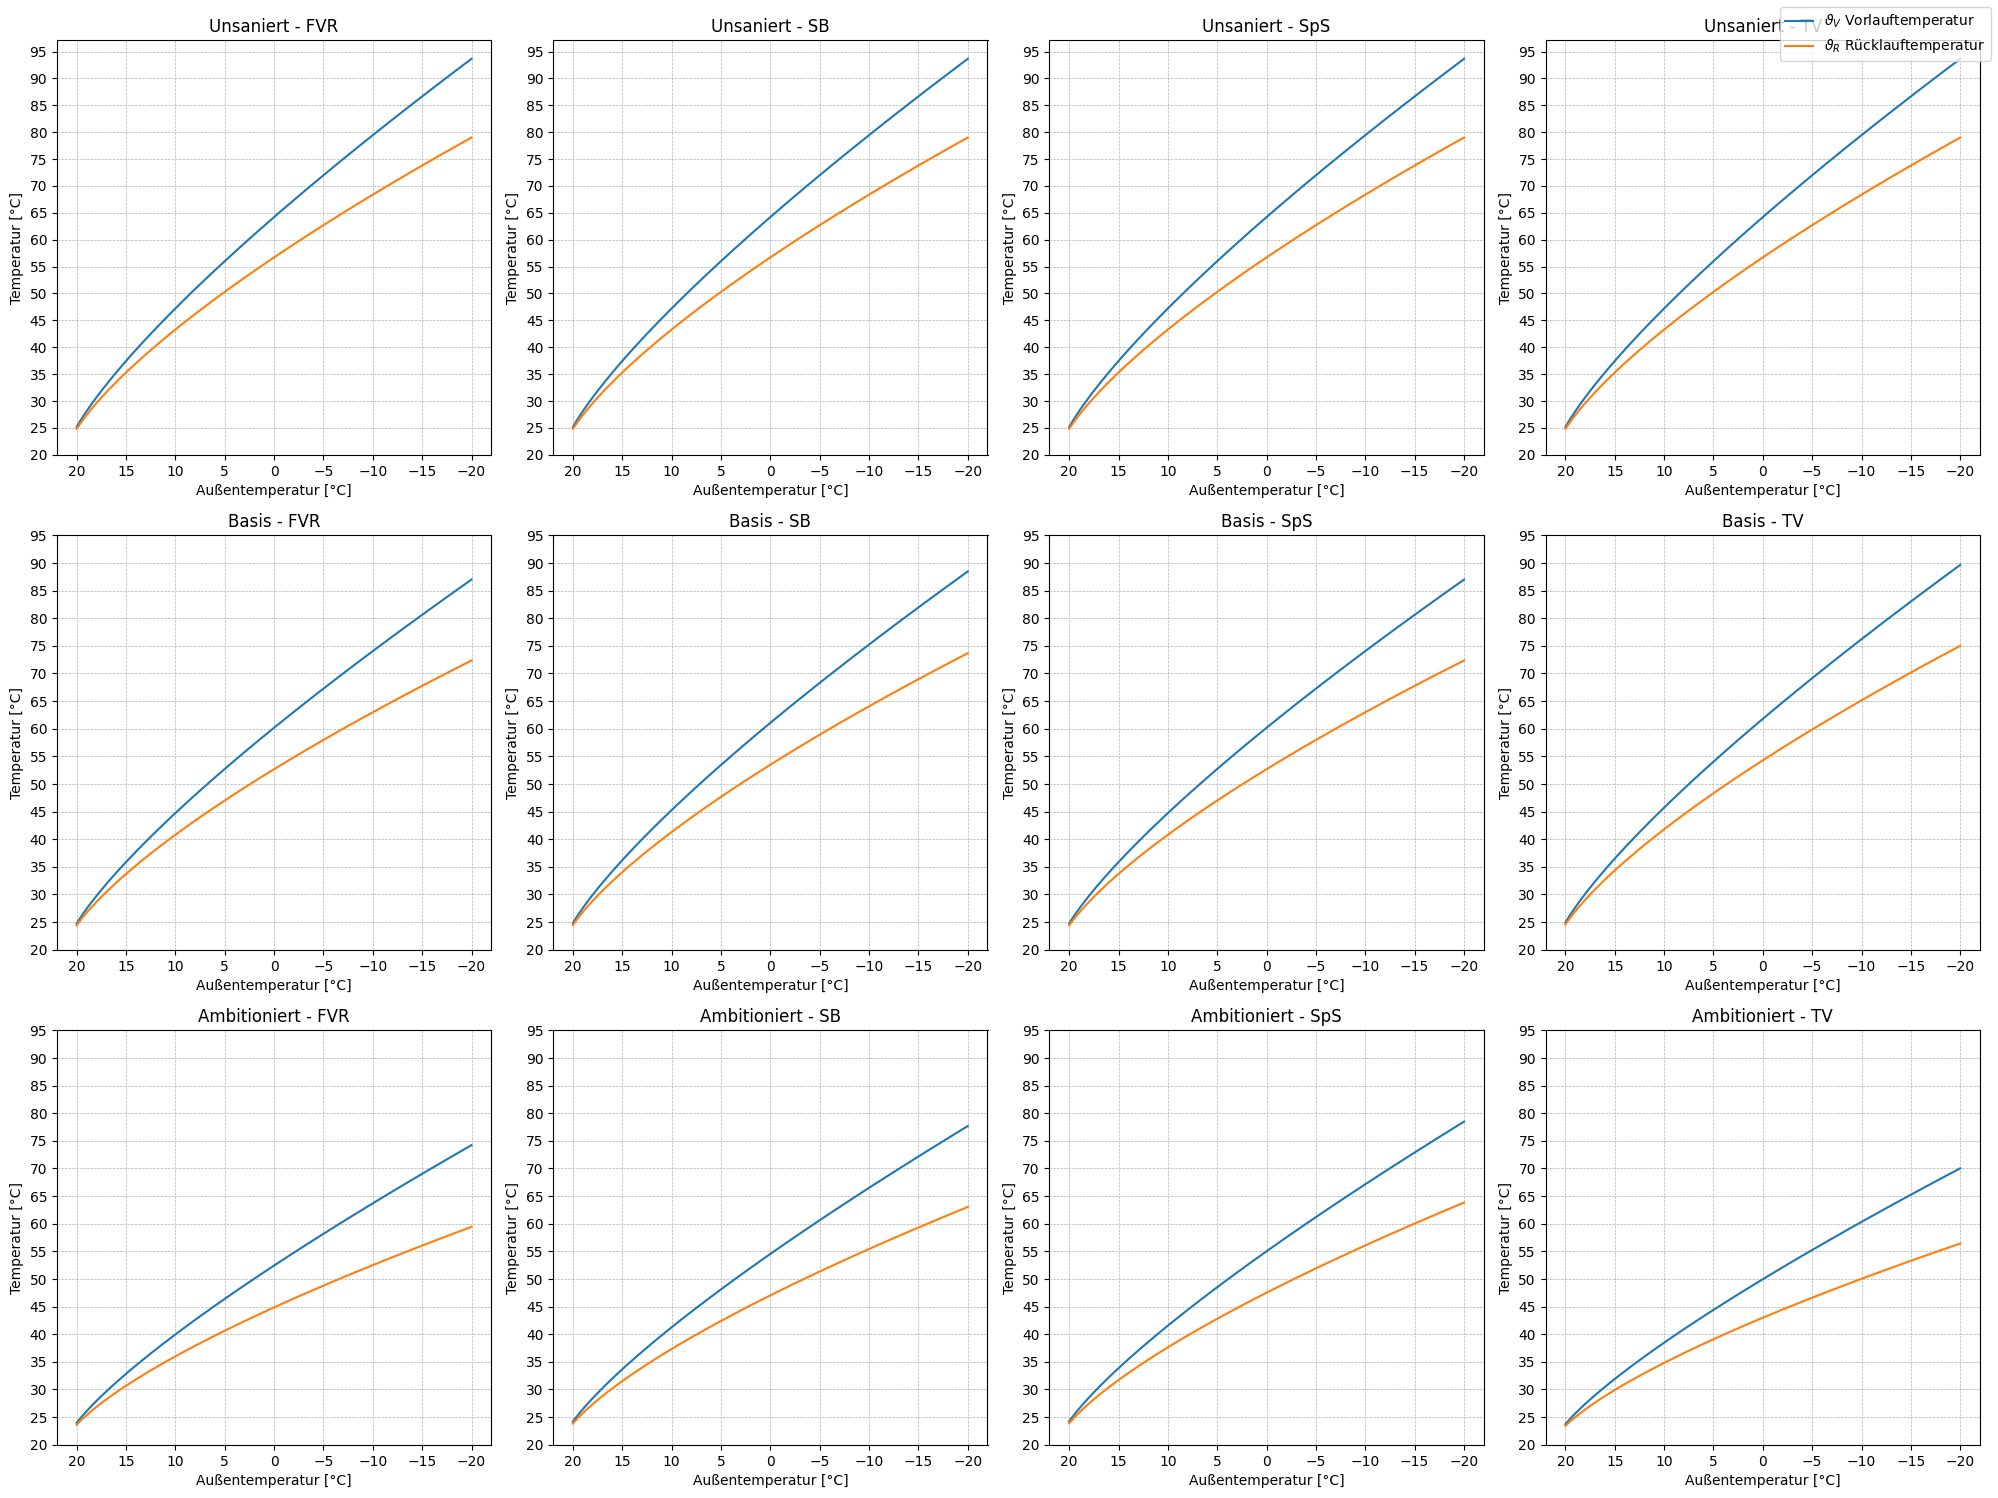

In [13]:
def plotHeizkurve(heizkurve,ax=None):
    T_a = np.linspace(-20, 20, 100)
    T_V, T_R = heizkurve
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(T_a, T_V(T_a))
    ax.plot(T_a, T_R(T_a))
    ax.set_xlabel('Außentemperatur [°C]')
    ax.set_ylabel('Temperatur [°C]')
    ax.invert_xaxis()
    ax.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    ax.set_xticks(np.arange(-20, 25, 5))
    ax.set_yticks(np.arange(20, 100, 5))

fig, axs = plt.subplots(3,4, figsize=(20,15), sharey=False)
for i, (variante, gebaeude) in enumerate(heizkurven):
    ax = axs.flatten()[i]
    plotHeizkurve(heizkurven[variante,gebaeude],ax=ax)
    ax.set_title(f"{variante} - {gebaeude}")
fig.legend(["$\\vartheta_V$ Vorlauftemperatur", "$\\vartheta_R$ Rücklauftemperatur"], loc='upper right')
plt.tight_layout()

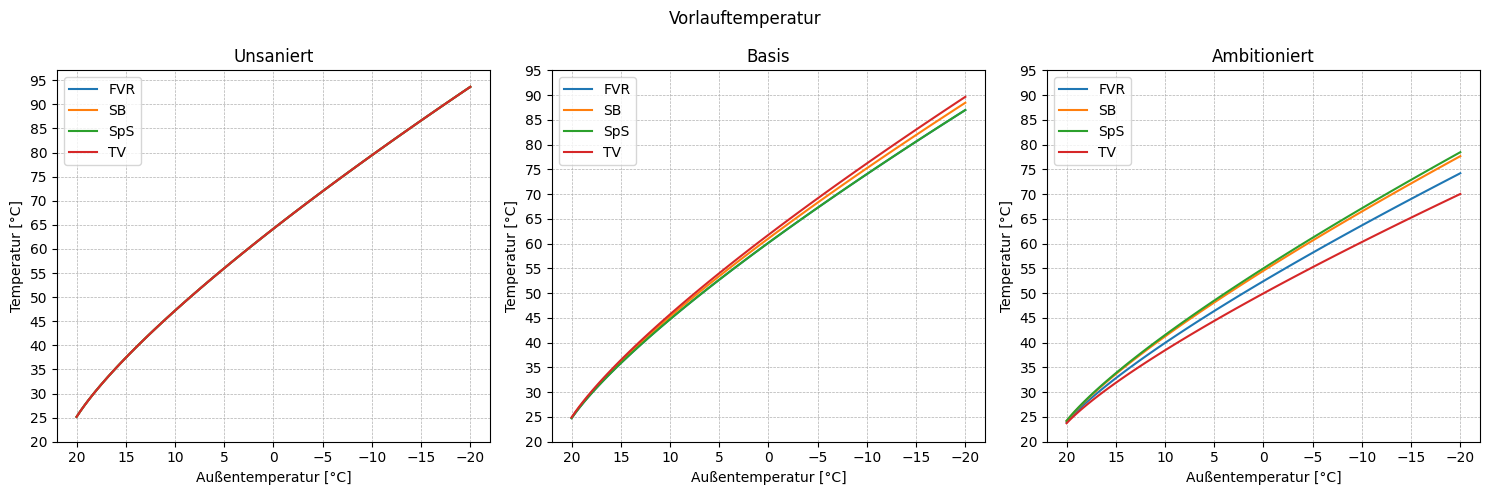

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=False)
for i, variante in enumerate(dfs):
    ax = axs.flatten()[i]
    for gebaeude in dfs[variante]:
        T_V, T_R = heizkurven[variante,gebaeude]
        T_a = np.linspace(-20, 20, 100)
        ax.plot(T_a, T_V(T_a), label=gebaeude)
    ax.set_title(variante)
    ax.set_xlabel('Außentemperatur [°C]')
    ax.set_ylabel('Temperatur [°C]')
    ax.invert_xaxis()
    ax.legend()
    ax.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    ax.set_xticks(np.arange(-20, 25, 5))
    ax.set_yticks(np.arange(20, 100, 5))

fig.suptitle('Vorlauftemperatur')
plt.tight_layout()

# output data for each plot into a separate CSV file with multiple sheets
with pd.ExcelWriter(r'C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Input_Data\VLT_RLT\7_Output_Heizkurven.xlsx') as writer:
    for variante in dfs:
        for gebaeude in dfs[variante]:
            T_V, T_R = heizkurven[variante,gebaeude]
            T_a = np.linspace(-20, 20, 100)
            df = pd.DataFrame({
                'T_a': T_a,
                'theta_V': T_V(T_a),
                'theta_R': T_R(T_a)
            })
            df.to_excel(writer, sheet_name=f'{variante}_{gebaeude}', index=False)


In [15]:
# Vorlauftemperaturen bei -7°C
for variante in dfs:
    for gebaeude in dfs[variante]:
        T_V, T_R = heizkurven[variante,gebaeude]
        print(f"{variante}_{gebaeude}: {T_V(-7)}")



Unsaniert_FVR: 75.00000000000009
Unsaniert_SB: 75.00000000000009
Unsaniert_SpS: 75.00000000000009
Unsaniert_TV: 75.00000000000009
Basis_FVR: 69.99999999999994
Basis_SB: 71.10000000000002
Basis_SpS: 69.99999999999994
Basis_TV: 71.99999999999993
Ambitioniert_FVR: 60.40000000000004
Ambitioniert_SB: 63.00000000000002
Ambitioniert_SpS: 63.60000000000003
Ambitioniert_TV: 57.29999999999998


------
# NT Wärmenetz Input Data
## Vorlauftermperatur WN für TRNSYS Basis NT

72.40694771641624


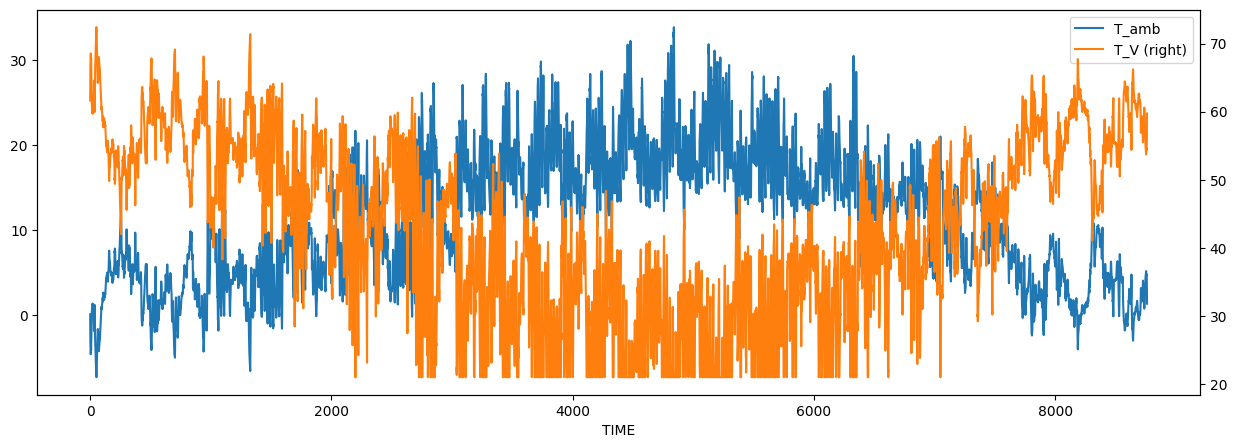

In [16]:
#Auswahl schlechteste Heizkurve TV
# #import data from T_amb.out file from path "C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\6_Gesamtsysteme_REP\TRNSYS\TRY2015_503413075920_Jahr.dat"
path = "C:\\Users\\lbarnic\\OneDrive - Fraunhofer\\A_Bearbeitung\\6_Gesamtsysteme_REP\\TRNSYS\\T_amb.out"
df = pd.read_csv(path, header=0, sep='\\s+', index_col=0, skipinitialspace=True)
df.columns = ['T_amb']

T_V_von_Ta, T_R_von_Ta = heizkurven["Basis","TV"]
df["T_V"] = T_V_von_Ta(df["T_amb"])

T_grenz = dfs["Basis"].loc["T_aGrenz","TV"]
# fill nans with T_a,grenz
df["T_V"] = df["T_V"].fillna(T_grenz)

df.to_csv("Outputs\\7_VLT_Basis_NT_TV.csv")
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Input_Data\VLT_RLT\7_VLT_Basis_NT_TV.csv")
# plot df["TV"]

df.plot(y=["T_amb", "T_V"], secondary_y="T_V", figsize=(15,5))
#maximaler Wert der Vorlauftemperatur
print(df["T_V"].max())

## Vorlauftemperatur Basis alle Gebäude

In [17]:
#import data from T_amb.out file from path "C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\6_Gesamtsysteme_REP\TRNSYS\TRY2015_503413075920_Jahr.dat"
path = "C:\\Users\\lbarnic\\OneDrive - Fraunhofer\\A_Bearbeitung\\6_Gesamtsysteme_REP\\TRNSYS\\T_amb.out"
df = pd.read_csv(path, header=0, sep='\\s+', index_col=0, skipinitialspace=True)
df.columns = ['T_amb']

# HT T_R
selected = [('Basis', 'FVR'), ('Basis', 'SB'), ('Basis', 'SpS'), ('Basis', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"VLT_{gebaeude}"] = T_V_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"VLT_{gebaeude}"] = df[f"VLT_{gebaeude}"].fillna(T_grenz)


# #plot HT
df.to_csv("Outputs\\7_VLT_Basis_NT_allbuidings.csv")
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Input_Data\VLT_RLT\7_VLT_Basis_NT_allbuildings.csv")
# df.plot(subplots=True,figsize=(15,15), title="HT")

## RLT Basis alle Gebäude

In [18]:
#import data from T_amb.out file from path "C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\6_Gesamtsysteme_REP\TRNSYS\TRY2015_503413075920_Jahr.dat"
path = "C:\\Users\\lbarnic\\OneDrive - Fraunhofer\\A_Bearbeitung\\6_Gesamtsysteme_REP\\TRNSYS\\T_amb.out"
df = pd.read_csv(path, header=0, sep='\\s+', index_col=0, skipinitialspace=True)
df.columns = ['T_amb']

# HT T_R
selected = [('Basis', 'FVR'), ('Basis', 'SB'), ('Basis', 'SpS'), ('Basis', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"RLT_{gebaeude}"] = T_R_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"RLT_{gebaeude}"] = df[f"RLT_{gebaeude}"].fillna(T_grenz)


# #plot HT
df.to_csv("Outputs\\7_RLT_Basis_NT_allbuildings.csv")
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Input_Data\VLT_RLT\7_RLT_Basis_NT_allbuidlings.csv")
# df.plot(subplots=True,figsize=(15,15), title="HT")


------
# KT Wärmenetz + Dezentral Input Data
## Vorlauftermperatur für TRNSYS Ambitioniert

## Vorlauftemperatur KT + Dezentral all buildings

In [19]:
#NT T_R
selected = [('Ambitioniert', 'FVR'), ('Ambitioniert', 'SB'), ('Ambitioniert', 'SpS'), ('Ambitioniert', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"VLT_{gebaeude}"] = T_V_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"VLT_{gebaeude}"] = df[f"VLT_{gebaeude}"].fillna(T_grenz)

# #plot NT
df.to_csv("Outputs\\7_VLT_Ambitioniert_allbuildings.csv")
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Input_Data\VLT_RLT\7_VLT_Ambitioniert_allbuildings.csv")
# df.plot(subplots=True,figsize=(15,15), title="NT")


## Rücklauftemperatur KT + Dezentral all buildings

In [20]:

#NT T_R
selected = [('Ambitioniert', 'FVR'), ('Ambitioniert', 'SB'), ('Ambitioniert', 'SpS'), ('Ambitioniert', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"RLT_{gebaeude}"] = T_R_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"RLT_{gebaeude}"] = df[f"RLT_{gebaeude}"].fillna(T_grenz)

# #plot NT
df.to_csv("Outputs\\7_RLT_Ambitioniert_allbuildings.csv")
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Input_Data\VLT_RLT\7_RLT_Ambitioniert_allbuidlings.csv")
# df.plot(subplots=True,figsize=(15,15), title="NT")

<Axes: xlabel='TIME'>

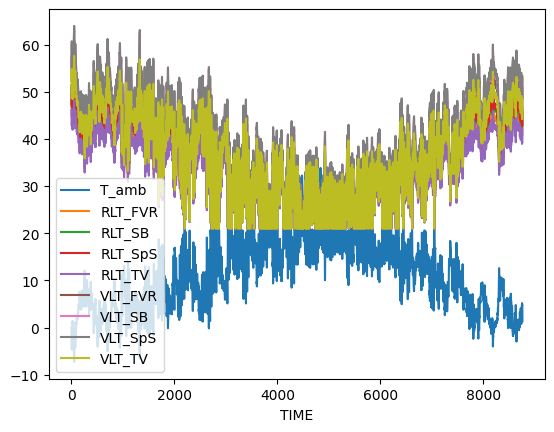

In [21]:
df.plot()

In [22]:
# mean temperature outside
df["T_amb"].mean()
# min temperatur outside und Zeitpunkt
df["T_amb"].min(), df["T_amb"].idxmin()



(np.float64(-7.287499999999999), np.float64(52.5))

## Lastgang 

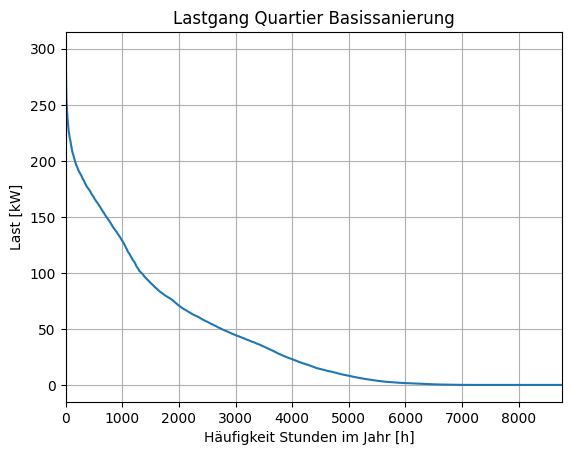

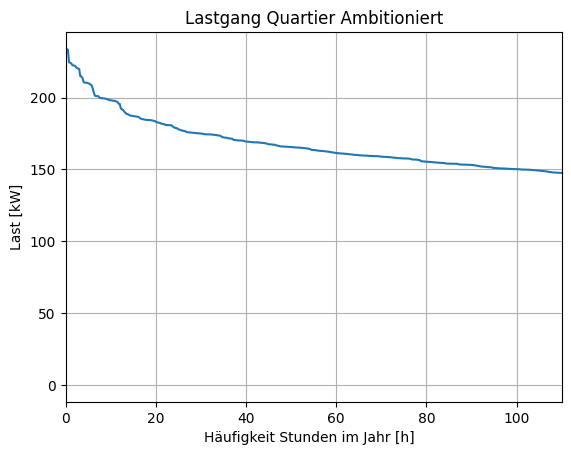

In [38]:
import numpy as np
# BASIS
#input data from path als csv datei als df buildings_dfs_basis
path = r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\5_Ermittlung_der_Sanierungspotenziale_REP\5_4_Bestimmung_Lastprofile\Input_Data\Basissanierung\buildings_dfs_basis.csv"
buildings_dfs_basis = pd.read_csv(path, index_col=0, header=[0,1])
buildings_dfs_basis = buildings_dfs_basis.drop(columns=[col for col in buildings_dfs_basis.columns if 'QCOOL' in col])


# audsummieren je Zeile
buildings_dfs_basis_sum = buildings_dfs_basis.sum(axis=1)
buildings_dfs_basis_sum = buildings_dfs_basis_sum.sort_values(ascending=False).reset_index(drop=True)
#plot
fig, ax = plt.subplots()
# ax.plot(np.arange(0,8760.25,0.25),buildings_dfs_basis_sum)
ax.plot(np.arange(0,8760.25,0.25),buildings_dfs_basis_sum)
ax.set_title(f"Lastgang Quartier Basissanierung")
ax.set_xlabel('Häufigkeit Stunden im Jahr [h]  ')
ax.set_ylabel('Last [kW]')
ax.grid()
ax.set_xlim(0,8760)
# ausgeben der quantile
buildings_dfs_basis_sum.quantile([1,0.975,0.95])
#wert bei x=100
buildings_dfs_basis_sum[8760]

# AMBITIONIERT
import numpy as np
#input data from path als csv datei als df buildings_dfs_basis
path = r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\5_Ermittlung_der_Sanierungspotenziale_REP\5_4_Bestimmung_Lastprofile\Input_Data\Ambitionierte_Sanierung\buildings_dfs_ambitioniert.csv"
buildings_dfs_ambitioniert = pd.read_csv(path, index_col=0, header=[0,1])
buildings_dfs_ambitioniert = buildings_dfs_ambitioniert.drop(columns=[col for col in buildings_dfs_ambitioniert.columns if 'QCOOL' in col])


# audsummieren je Zeile
buildings_dfs_ambitioniert_sum = buildings_dfs_ambitioniert.sum(axis=1)
buildings_dfs_ambitioniert_sum = buildings_dfs_ambitioniert_sum.sort_values(ascending=False).reset_index(drop=True)
#plot
fig, ax = plt.subplots()
ax.plot(np.arange(0,8760.25,0.25),buildings_dfs_ambitioniert_sum)
ax.set_title(f"Lastgang Quartier Ambitioniert")
ax.set_xlabel('Häufigkeit Stunden im Jahr [h]  ')
ax.set_ylabel('Last [kW]')
ax.grid()
ax.set_xlim(0,110)

buildings_dfs_ambitioniert_sum.quantile([1,0.975,0.95])


#export excel sheet for ambotioniert and basis
with pd.ExcelWriter( r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Lastgänge\7_Output_Lastgänge.xlsx") as writer:
    buildings_dfs_ambitioniert_sum.to_excel(writer, sheet_name='Ambitioniert')
    buildings_dfs_basis_sum.to_excel(writer, sheet_name='Basis')


 
# # Last gang je Gebäude create for loop for every single column (braucht man vermutlich nicht)
# for col in buildings_dfs_basis.columns:
#     buildings_dfs_basis[col] = buildings_dfs_basis[col].sort_values(ascending=False).reset_index(drop=True)
#     # plot the sorted values
#     fig, ax = plt.subplots()
#     ax.plot(np.arange(0,8760.25,0.25),buildings_dfs_basis[col])
#     ax.set_title(f"Lastgang {col}")
#     ax.set_xlabel('Häufigkeit des Auftretens')
#     ax.set_ylabel('Last')
#     ax.set_yticks(np.arange(0, 140, 10))
#     ax.grid()
#     ax.set_ylim(0,140)
   

# buildings_dfs_basis
# buildings_dfs_basis.sort_values(ascending=False)
# buildings_dfs_basis

#Wert von 1 --> Wärmespeicherdimensionierung

# Sondendimensionerung


In [39]:
#drop multiindex
buildings_dfs_ambitioniert = buildings_dfs_ambitioniert.droplevel(1,axis=1)

In [42]:
buildings_dfs_basis_sum.quantile(0.975) # NTWN
COP = {
    'FVR': 2.66,
    'SB': 2.66,
    'SpS': 2.62,
    'TV': 2.9
}

# multipliziere COP des Gebäude mit Last des Gebäudes
buildings_dfs_ambitioniert_Umweltwaerme = buildings_dfs_ambitioniert * (1-1/pd.Series(COP))
Verdampferleistung_KNW = buildings_dfs_ambitioniert_Umweltwaerme.sum(axis=1).quantile(0.975) # je Zeitschritt 97,5% Quantil
Verdampferleistung_KNW

#dezentral
Verdampferleistung_dez = buildings_dfs_ambitioniert_Umweltwaerme.quantile(0.975) # je Zeitschritt 97,5% Quantil
Verdampferleistung_dez


FVR    10.341181
SB     28.786915
SpS    39.436963
TV      7.713499
Name: 0.975, dtype: float64

In [45]:
Verdampferleistung_KNW = buildings_dfs_ambitioniert_Umweltwaerme.sum(axis=1).quantile(0.975) # je Zeitschritt 97,5% Quantil
Verdampferleistung_dez = buildings_dfs_ambitioniert_Umweltwaerme.quantile(0.975).sum()
Verdampferleistung_KNW, Verdampferleistung_dez

(np.float64(82.6115243610862), np.float64(86.27855781715917))

In [44]:
Verdampferleistung_KNW = buildings_dfs_ambitioniert_Umweltwaerme.sum(axis=1).max() # je Zeitschritt 97,5% Quantil
Verdampferleistung_dez = buildings_dfs_ambitioniert_Umweltwaerme.max().sum()
Verdampferleistung_KNW, Verdampferleistung_dez

(np.float64(145.99489582132034), np.float64(152.9130181352501))

# Lastgang Ambitioniert je Gebäude

,FVR,SB,SpS,TV
,QHEAT,QHEAT,QHEAT,QHEAT
1.000,32.354000,98.008537,94.042916,20.468322
0.975,16.570809,46.128430,63.780767,11.773235
0.950,13.588457,35.902124,56.576689,10.022422


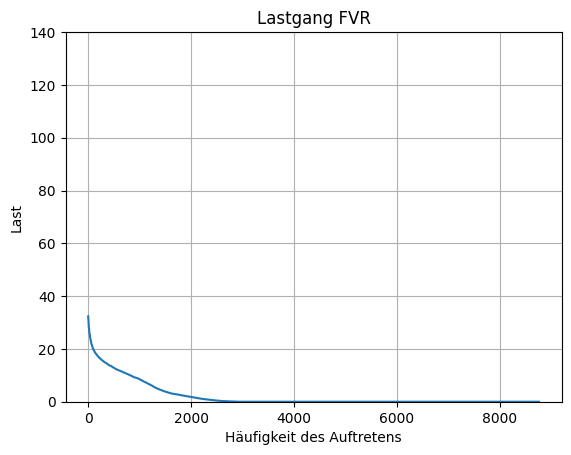

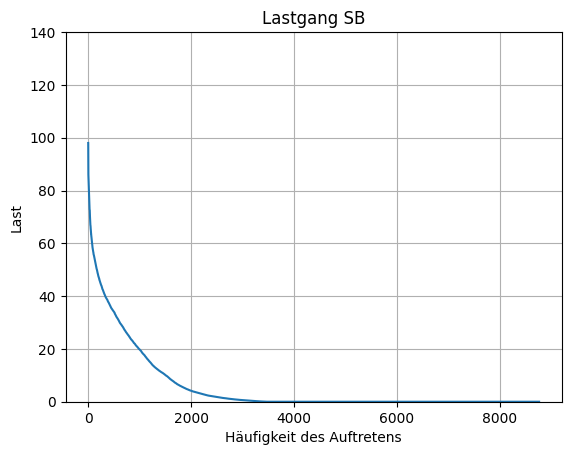

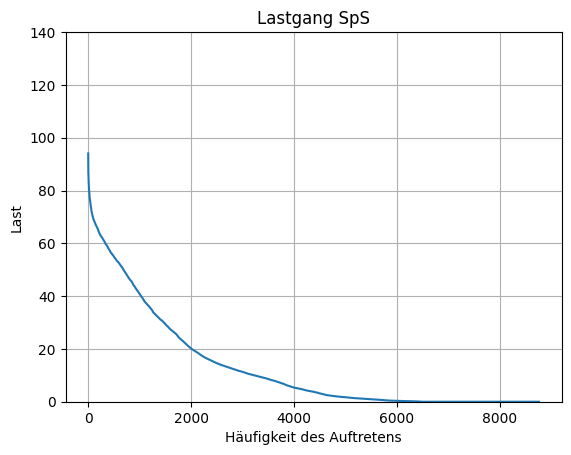

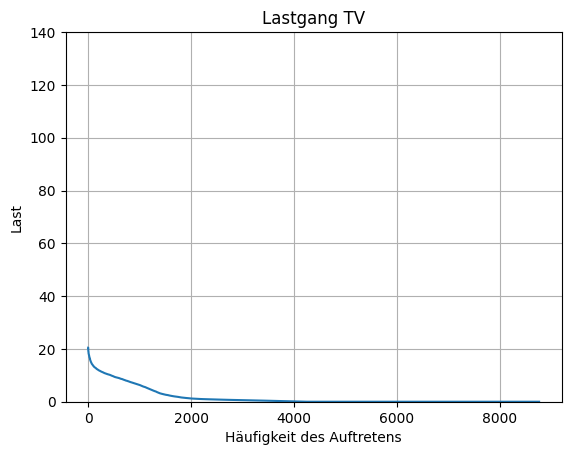

In [38]:
# loop buildings
for col in buildings_dfs_ambitioniert.columns:
    buildings_dfs_ambitioniert[col] = buildings_dfs_ambitioniert[col].sort_values(ascending=False).reset_index(drop=True)
    # plot the sorted values
    fig, ax = plt.subplots()
    ax.plot(np.arange(0,8760.25,0.25),buildings_dfs_ambitioniert[col])
    ax.set_title(f"Lastgang {col[0]}")
    ax.set_xlabel('Häufigkeit des Auftretens')
    ax.set_ylabel('Last')
    ax.grid()
    ax.set_ylim(0,140)

#export excel sheet
with pd.ExcelWriter( r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\Lastgänge\7_Output_Lastgänge_all_buildings.xlsx") as writer:
    buildings_dfs_ambitioniert.to_excel(writer, sheet_name='Ambitioniert')

# Quantile berechnen
buildings_dfs_ambitioniert.quantile([1,0.975,0.95])

In [25]:
# buildings_dfs_basis = pd.read_csv(path, index_col=0, header=[0,1])
# q_total = buildings_dfs_basis.xs('QHEAT', axis=1, level=1).sum(axis=1)
# q_total[:24*7].plot()
# # moving average over 4 values
# q_with_storage = q_total.rolling(4).mean()
# q_with_storage[:24*7].plot()

# fig, ax = plt.subplots()
# q_with_storage.sort_values(ascending=False).reset_index(drop=True).plot()
# q_with_storage.quantile([1,0.95,0.9,0.75, 0.5, 0.25])